# Adversarial Attacks on Pretrained Vision Models

In this notebook, I will demonstrate how to perform adversarial attacks on a pretrained vision model without retraining it. The workflow will be as follows:

1. **Model Selection**: Load a pretrained vision model (e.g., ResNet, VGG) from a popular library such as PyTorch or TensorFlow.
2. **Dataset**: Use images from the ImageNet dataset, focusing on a specific class for targeted attacks.
3. **Prediction**: Pass the selected images through the model to obtain baseline predictions.
4. **Adversarial Attack**: Apply an adversarial attack method (e.g., FGSM, PGD) to the images of the chosen class.
5. **Evaluation**: Compare the model's predictions on clean vs. adversarial images to assess the effectiveness of the attack.

No model training will be performed; the focus is solely on testing and attacking the pretrained model using ImageNet class images.

In [13]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained VGG16 model
model = models.vgg16(pretrained=True)
model.eval()  # Set model to evaluation mode

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
from PIL import Image
from torchvision import transforms
import json
import requests

# Load and preprocess the image
img_path = '../dataset/parachute.jfif'
image = Image.open(img_path).convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Inference
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = output.max(1)

# Download ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
labels = requests.get(LABELS_URL).text.splitlines()


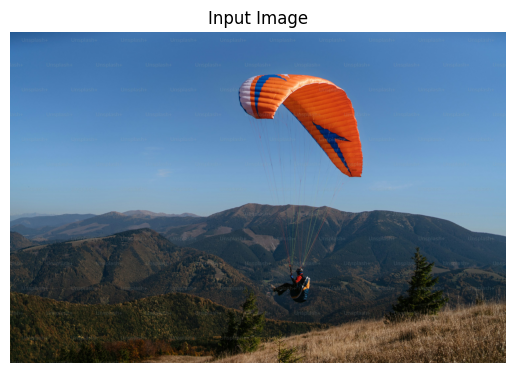

Predicted class: parachute


In [15]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title('Input Image')
plt.show()

# Print predicted class
print('Predicted class:', labels[predicted.item()])

In [16]:
# Get top 5 predictions and their probabilities
with torch.no_grad():
    probs = torch.nn.functional.softmax(output, dim=1)
    top5_probs, top5_indices = probs.topk(5, dim=1)

# Display top 5 predicted classes and probabilities
for i in range(5):
    idx = top5_indices[0, i].item()
    prob = top5_probs[0, i].item()
    print(f"{i+1}. {labels[idx]} ({prob:.4f})")

1. parachute (0.9952)
2. balloon (0.0045)
3. mountain tent (0.0001)
4. umbrella (0.0000)
5. airship (0.0000)


## FGSM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27815685081481933..0.4850000040531159].


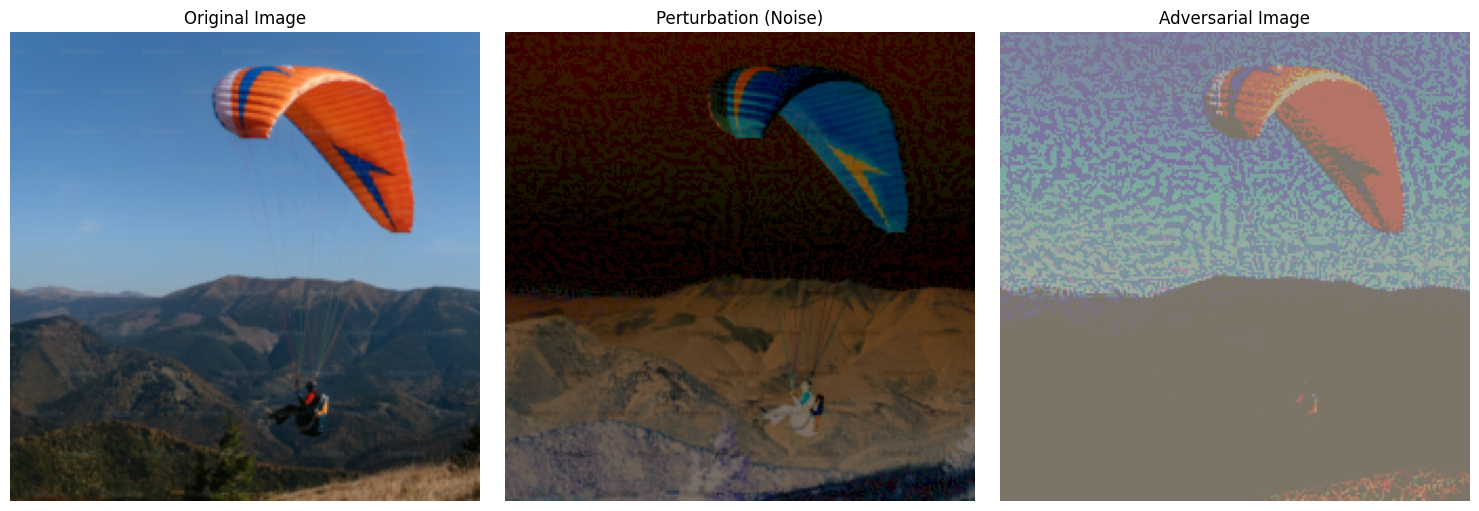

In [17]:
import sys
sys.path.append('../attacks')
from fgsm import FGSM

# Prepare label for untargeted attack (use predicted label)
label_tensor = torch.tensor([predicted.item()])

# Instantiate FGSM
epsilon = 0.4  
fgsm = FGSM(epsilon=epsilon, targeted=False)

# Generate adversarial example
adv_image = fgsm.attack(model, input_tensor, label_tensor)

# Display adversarial image
adv_img_np = adv_image.squeeze().detach().cpu().numpy().transpose(1,2,0)
adv_img_np = adv_img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
adv_img_np = adv_img_np.clip(0, 1)

# Calculate perturbation
perturbation = (adv_image - input_tensor).squeeze().detach().cpu().numpy().transpose(1,2,0)
perturbation = perturbation * [0.229, 0.224, 0.225]  # Unnormalize (no mean added for noise)
perturbation = perturbation.clip(-0.5, 0.5)  # Clip for visualization

# Show original image
orig_img_np = input_tensor.squeeze().detach().cpu().numpy().transpose(1,2,0)
orig_img_np = orig_img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
orig_img_np = orig_img_np.clip(0, 1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(orig_img_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(perturbation, cmap='seismic')
axs[1].set_title('Perturbation (Noise)')
axs[1].axis('off')

axs[2].imshow(adv_img_np)
axs[2].set_title('Adversarial Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

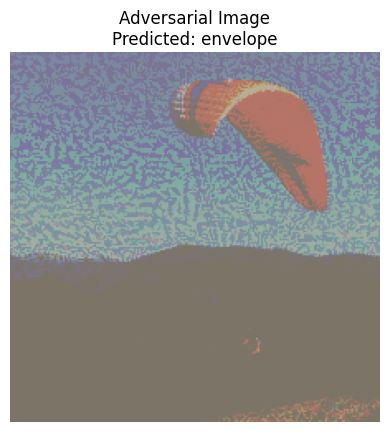

In [18]:
# Predict the label of the adversarial image
with torch.no_grad():
    adv_output = model(adv_image)
    _, adv_predicted = adv_output.max(1)

# Show adversarial image with predicted label
plt.imshow(adv_img_np)
plt.axis('off')
plt.title(f'Adversarial Image\nPredicted: {labels[adv_predicted.item()]}')
plt.show()

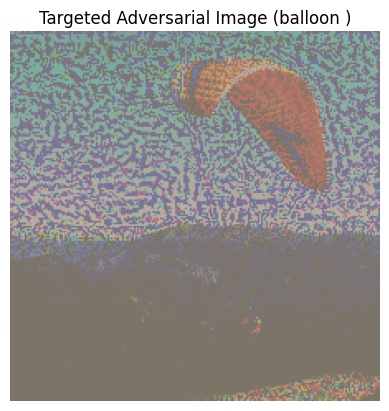

Predicted class for targeted attack: prayer rug


In [19]:
# Find the ImageNet class index for 'balloon '
target_class_name = 'balloon'
target_class_idx = labels.index(target_class_name)  # Get index for balloon 
target_label_tensor = torch.tensor([target_class_idx])

# Instantiate FGSM for targeted attack
epsilon = 0.9  
fgsm_targeted = FGSM(epsilon=epsilon, targeted=True)

# Generate targeted adversarial example
adv_image_targeted = fgsm_targeted.attack(model, input_tensor, target_label_tensor)

# Display targeted adversarial image
adv_img_targeted_np = adv_image_targeted.squeeze().detach().cpu().numpy().transpose(1,2,0)
adv_img_targeted_np = adv_img_targeted_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
adv_img_targeted_np = adv_img_targeted_np.clip(0, 1)

plt.imshow(adv_img_targeted_np)
plt.axis('off')
plt.title('Targeted Adversarial Image (balloon )')
plt.show()

# Predict the label of the targeted adversarial image
with torch.no_grad():
    adv_output_targeted = model(adv_image_targeted)
    _, adv_predicted_targeted = adv_output_targeted.max(1)

print(f"Predicted class for targeted attack: {labels[adv_predicted_targeted.item()]}")

## BIM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.27815685081481933..0.4850000040531159].


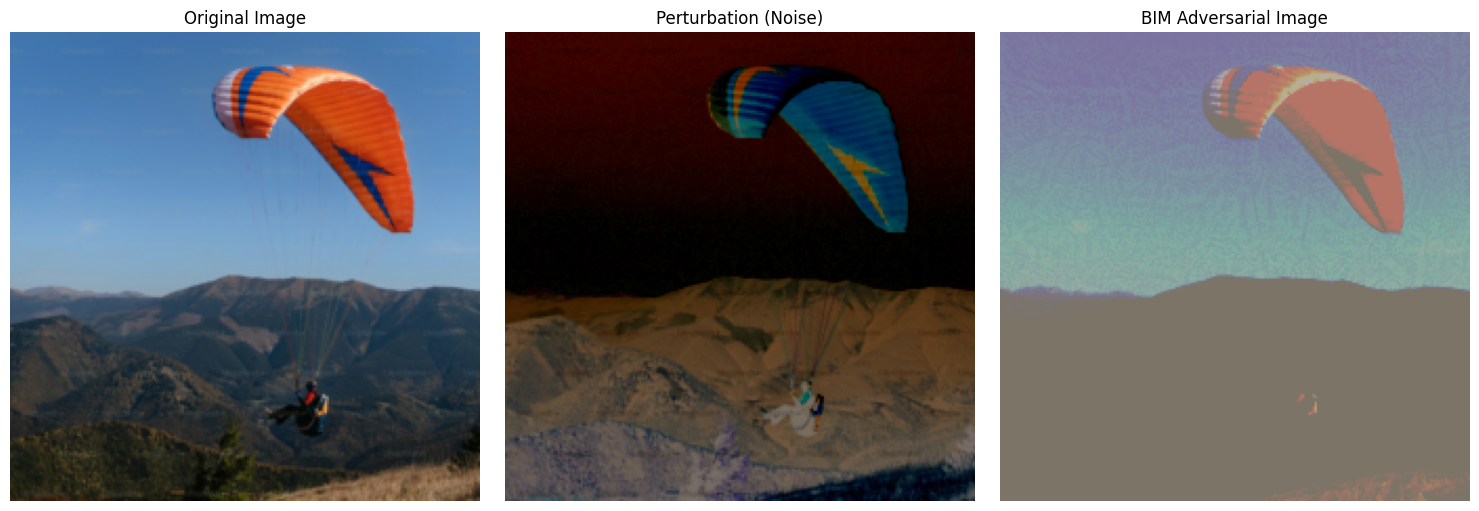

Predicted class for BIM targeted attack: balloon


In [20]:
# Targeted BIM attack to force prediction as 'balloon'
import sys
sys.path.append('../attacks')
from bim import BIM

# BIM parameters
epsilon = 0.1
alpha = 0.1
num_iterations = 60
targeted = True


# Instantiate BIM for targeted attack
bim_targeted = BIM(epsilon=epsilon, alpha=alpha, num_iterations=num_iterations, targeted=targeted)

# Generate targeted adversarial example
adv_image_bim = bim_targeted.attack(model, input_tensor, target_label_tensor)

# Display targeted adversarial image
adv_img_bim_np = adv_image_bim.squeeze().detach().cpu().numpy().transpose(1,2,0)
adv_img_bim_np = adv_img_bim_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
adv_img_bim_np = adv_img_bim_np.clip(0, 1)
# Show original image, perturbation, and BIM adversarial image side by side
perturbation_bim = (adv_image_bim - input_tensor).squeeze().detach().cpu().numpy().transpose(1,2,0)
perturbation_bim = perturbation_bim * [0.229, 0.224, 0.225]  # Unnormalize (no mean added for noise)
perturbation_bim = perturbation_bim.clip(-0.5, 0.5)  # Clip for visualization

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(orig_img_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(perturbation_bim, cmap='seismic')
axs[1].set_title('Perturbation (Noise)')
axs[1].axis('off')

axs[2].imshow(adv_img_bim_np)
axs[2].set_title('BIM Adversarial Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Predict the label of the BIM adversarial image
with torch.no_grad():
    adv_output_bim = model(adv_image_bim)
    _, adv_predicted_bim = adv_output_bim.max(1)

print(f"Predicted class for BIM targeted attack: {labels[adv_predicted_bim.item()]}")